# Find stats

for hichip figure plus supplements

05/08/2020

05/12/2020 - update how we find the promoter regions

updated 06/25/2021 with removing GDSD0 and GDSD3

In [9]:
import os, glob
import pandas as pd
import numpy as np
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
save_dir = '../data/processed/fig2_hichip'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
loop_files = glob.glob('../data/interim/merged/loops/*.loops.csv')
anchor_annon_dir = '../data/interim/annon/anchor_atac'
anchor_annon_files = glob.glob('../data/interim/annon/anchor_atac/*_annon.bed')
promoter_annon_dir = '../data/interim/annon/promoter_anchors/'
promoter_annon_files = glob.glob('../data/interim/annon/promoter_anchors/promoter_*_annon.bed')
# anchor_annon_files
anchor_dir = '../data/interim/merged/anchors/'
anchor_files = glob.glob('../data/interim/merged/anchors/*.anchors.csv')

In [4]:
normal_tissues = ['Airway','Astrocytes','Bladder','Colon','Esophageal',
# 'GDSD0',
# 'GDSD3',
'GDSD6',
'GM12878',
'HMEC',
'Melanocytes',
'Ovarian',
'Pancreas',
'Prostate',
'Renal',
'Thyroid',
'Uterine']



# 1. Find Stats of of distribution of loop width

In [5]:
%%time
loop_width_df = pd.DataFrame(columns=['loop_width','tissue'])
for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    loop_df = pd.read_csv(loop_file, index_col=0)
    loop_df[['chrA','startA','stopA']] = loop_df.source.str.split('_',expand=True)
    loop_df[['chrB','startB','stopB']] = loop_df.target.str.split('_',expand=True)
    loop_df['loop_width'] = loop_df.startB.map(int) - loop_df.startA.map(int)
    loop_df['tissue'] = tissue
    loop_width_df = pd.concat([loop_width_df, loop_df[['loop_width', 'tissue']]])
    print(tissue, loop_width_df.shape)
    


A431-CTRLi (793614, 2)
A431-p63i (1398601, 2)
Airway (1455876, 2)
Astrocytes (1650558, 2)
Bladder (1831242, 2)
CAL27-CTRLi (2709623, 2)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CAL27-p63i (3782556, 2)
COLO_SCR_DMSO (4026414, 2)
COLO_SCR_PLX (4140030, 2)
COLO_shMITF_DMSO (4353493, 2)
COLO_shMITF_PLX (4473378, 2)
Colon (4700098, 2)
D0-CTRLi (5256896, 2)
D0-p63i (5858510, 2)
D3-CTRLi (6206514, 2)
D3-p63i (6556400, 2)
D6-CTRLi (7120982, 2)
D6-p63i (7522441, 2)
Esophageal (7736099, 2)
GDSD0 (7906815, 2)
GDSD3 (8094624, 2)
GDSD6 (8264990, 2)
GM12878 (8432337, 2)
HMEC (8542513, 2)
Melanocytes (8624637, 2)
Ovarian (8803466, 2)
Pancreas (8958826, 2)
Prostate (9224818, 2)
Renal (9448707, 2)
SCC13-CTRLi (10173950, 2)
SCC13-p63i (10871602, 2)
Thyroid (11045589, 2)
Uterine (11466681, 2)
WM_SCR_DMSO (11901547, 2)
WM_SCR_PLX (12256310, 2)
WM_shMITF_DMSO (12778399, 2)
WM_shMITF_PLX (13249551, 2)
CPU times: user 3min 44s, sys: 6.44 s, total: 3min 51s
Wall time: 2min 12s


In [6]:
loop_width_normal_df = loop_width_df[loop_width_df.tissue.isin(normal_tissues)]
print(loop_width_df.shape, loop_width_normal_df.shape)
loop_width_df.to_csv(os.path.join(save_dir, 'loop_width_df.csv'))
loop_width_normal_df.to_csv(os.path.join(save_dir, 'loop_width_normal_df.csv'))
# loop_width_df[:5]
# loop_width_df_test = loop_width_df[(loop_width_df.tissue=='Air')|(loop_width_df.tissue=='MC') ]

(13249551, 2) (2822181, 2)


# 2. Loop and Anchor statistics

for each tissue (split normal and all) get following stats
- num unique loops
- num unique anchors
- num common loops
- num common anchors 
- num loops
- num anchors 	

summative stats (across all tissues)
    - total number of distinct anchors
    - total number of distinct loops

In [5]:
%%time
# first get set of all loops
# all_loops, all_loops_normal = set(),set()
# all_anchors, all_anchors_normal = set(),set()

tissues = []
loops_all_df = pd.DataFrame(columns=['loop_name','tissue'])
anchors_all_df = pd.DataFrame(columns=['anchors','tissue'])

# tissue_info_dict = {}
for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    tissues.append(tissue)
    anchor_file = os.path.join(anchor_dir, tissue+'.anchors.csv')
    loop_df = pd.read_csv(loop_file, index_col=0)
    loop_df['loop_name'] = loop_df.apply(lambda row: '::'.join(sorted([row.source,row.target])),axis=1)
    loop_df['tissue'] = tissue
    
    anchor_df = pd.read_csv(anchor_file, index_col=0)
    anchor_df['tissue'] = tissue
   
    loops_all_df = pd.concat([loops_all_df, loop_df[['loop_name', 'tissue']]])
    anchors_all_df = pd.concat([anchors_all_df, anchor_df[['anchors', 'tissue']]])
    print(tissue)
    
#     tissue_info_dict[tissue] = [loop_df,anchor_df,anchor_to_count_dict]
    
#     all_loops  = all_loops.union(set(loop_df.loop_name))
#     all_anchors  = all_anchors.union(set(anchor_df.anchors))
                                         
#     if tissue in normal_tissues:
#         all_loops_normal = all_loops_normal.union(set(loop_df.loop_name))
#         all_anchors_normal = all_anchors_normal.union(set(anchor_df.anchors))                            
    

A431-CTRLi
A431-p63i
Airway
Astrocytes
Bladder
CAL27-CTRLi


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CAL27-p63i
COLO_SCR_DMSO
COLO_SCR_PLX
COLO_shMITF_DMSO
COLO_shMITF_PLX
Colon
D0-CTRLi
D0-p63i
D3-CTRLi
D3-p63i
D6-CTRLi
D6-p63i
Esophageal
GDSD0
GDSD3
GDSD6
GM12878
HMEC
Melanocytes
Ovarian
Pancreas
Prostate
Renal
SCC13-CTRLi
SCC13-p63i
Thyroid
Uterine
WM_SCR_DMSO
WM_SCR_PLX
WM_shMITF_DMSO
WM_shMITF_PLX
CPU times: user 7min 56s, sys: 4.81 s, total: 8min 1s
Wall time: 6min 2s


In [6]:
all_loops = loops_all_df.loop_name.unique()
all_loops_normal = loops_all_df.loop_name[loops_all_df.tissue.isin(normal_tissues)].unique()
all_anchors = anchors_all_df.anchors.unique()
all_anchors_normal = anchors_all_df.anchors[anchors_all_df.tissue.isin(normal_tissues)].unique()


In [7]:
# get loop/anchor by tissue binary matrix, 1 or 0 depending on whether loop/anchor exists in tissue
loops_all_df['count']=1
loop_counts = loops_all_df.pivot_table(index='loop_name', columns='tissue',values='count', fill_value=0)

anchors_all_df['count']=1
anchor_counts = anchors_all_df.pivot_table(index='anchors', columns='tissue',values='count', fill_value=0)

loop_counts_normal = loop_counts[normal_tissues]
anchor_counts_normal = anchor_counts[normal_tissues]



In [8]:
loop_counts['num_tissues'] = loop_counts.sum(axis=1)
loop_counts_normal['num_tissues'] = loop_counts_normal.sum(axis=1)
anchor_counts['num_tissues'] = anchor_counts.sum(axis=1)
anchor_counts_normal['num_tissues'] = anchor_counts_normal.sum(axis=1)

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
all_counts_results_df = pd.DataFrame()
all_counts_results_df['num_loops'] = loop_counts.sum(axis=0)
all_counts_results_df['num_unique_loops'] = loop_counts[loop_counts.num_tissues==1].sum()
all_counts_results_df['num_common_loops'] = loop_counts[loop_counts.num_tissues==(loop_counts.shape[1]-1)].sum()
all_counts_results_df['num_anchors'] = anchor_counts.sum(axis=0)
all_counts_results_df['num_unique_anchors'] = anchor_counts[anchor_counts.num_tissues==1].sum()
all_counts_results_df['num_common_anchors'] = anchor_counts[anchor_counts.num_tissues==(anchor_counts.shape[1]-1)].sum()
all_counts_results_df.drop('num_tissues',inplace=True)

In [10]:
all_counts_results_normal_df = pd.DataFrame()
all_counts_results_normal_df['num_loops'] = loop_counts_normal.sum(axis=0)
all_counts_results_normal_df['num_unique_loops'] = loop_counts_normal[loop_counts_normal.num_tissues==1].sum()
all_counts_results_normal_df['num_common_loops'] = loop_counts_normal[loop_counts_normal.num_tissues==(loop_counts_normal.shape[1]-1)].sum()
all_counts_results_normal_df['num_anchors'] = anchor_counts_normal.sum(axis=0)
all_counts_results_normal_df['num_unique_anchors'] = anchor_counts_normal[anchor_counts_normal.num_tissues==1].sum()
all_counts_results_normal_df['num_common_anchors'] = anchor_counts_normal[anchor_counts_normal.num_tissues==(anchor_counts_normal.shape[1]-1)].sum()
all_counts_results_normal_df.drop('num_tissues',inplace=True)

In [17]:
pd.DataFrame(loop_counts_normal.index[loop_counts_normal.num_tissues==15]).to_csv(os.path.join(save_dir, 'common_loops_normal.csv'))

In [13]:
all_counts_results_df.to_csv(os.path.join(save_dir, 'all_counts_results_df.csv'))
all_counts_results_normal_df.to_csv(os.path.join(save_dir, 'all_counts_results_normal_df.csv'))

In [14]:

print('Total # of loops all tissues: ',all_counts_results_df.num_loops.sum())
print('Total # unique loops all tissues: ',all_counts_results_df.num_unique_loops.sum())
print('Total # common loops all tissues: ',all_counts_results_df.num_common_loops[0])

print('Total # of anchors all samples: ',all_counts_results_df.num_anchors.sum())
print('Total # unique anchors all tissues: ',all_counts_results_df.num_unique_anchors.sum())
print('Total # common anchors all tissues: ',all_counts_results_df.num_common_anchors[0])

print()

print('Total # of loops normal tissues : ',all_counts_results_normal_df.num_loops.sum())
print('Total # unique loops normal tissues: ',all_counts_results_normal_df.num_unique_loops.sum())
print('Total # common loops normal tissues: ',all_counts_results_normal_df.num_common_loops[0])


print('Total # of anchors all samples normal: ',all_counts_results_normal_df.num_anchors.sum())
print('Total # unique anchors normal tissues: ',all_counts_results_normal_df.num_unique_anchors.sum())
print('Total # common anchors normal tissues: ',all_counts_results_normal_df.num_common_anchors[0])

Total # of loops all tissues:  13249551
Total # unique loops all tissues:  1235518
Total # common loops all tissues:  1529
Total # of anchors all samples:  4646665
Total # unique anchors all tissues:  49665
Total # common anchors all tissues:  5904

Total # of loops normal tissues :  2822181
Total # unique loops normal tissues:  592278
Total # common loops normal tissues:  3717
Total # of anchors all samples normal:  1414821
Total # unique anchors normal tissues:  75969
Total # common anchors normal tissues:  10117


## 2B. save lists of anchors and loops that have been annotated 

- find closest gene
- find common genes on loops 

In [21]:
anchors_all = anchor_counts.index
len(anchors_all)
anchors_bed = pybedtools.BedTool.from_dataframe(pd.Series(anchors_all).str.split('_',expand=True)).sort()

In [22]:
len(anchors_bed), len(anchors_all)

(394965, 394965)

In [23]:
tss_df = pd.read_csv('../data/external/gene_annon_hg19.csv',index_col=0)
tss_bed = pybedtools.BedTool.from_dataframe(tss_df[['chr','start','end', 'gene']]).sort()
len(tss_bed), len(tss_df)

(20314, 20314)

In [24]:
anchors_bed_closest_gene = anchors_bed.closest(tss_bed, d=True)
len(anchors_bed_closest_gene)
anchors_closest_gene_df = anchors_bed_closest_gene.to_dataframe()
anchors_closest_gene_df.columns = ['chr', 'start', 'stop', 'chr_tss', 'start_tss', 'stop_tss', 'gene', 'dist_to_TSS']
anchors_closest_gene_df['anchor_name'] = anchors_closest_gene_df.chr + '_' + anchors_closest_gene_df.start.map(str) + '_' + anchors_closest_gene_df.stop.map(str)
anchors_closest_gene_df.to_csv(os.path.join(save_dir, 'anchors_closest_gene_df.csv'))

In [25]:
anchors_closest_gene_df[:5]

,chr,start,stop,chr_tss,start_tss,stop_tss,gene,dist_to_TSS,anchor_name
0,chr1,710000,715000,chr1,738532,739137,AL669831.1,23533,chr1_710000_715000
1,chr1,715000,720000,chr1,738532,739137,AL669831.1,18533,chr1_715000_720000
2,chr1,720000,725000,chr1,738532,739137,AL669831.1,13533,chr1_720000_725000
3,chr1,725000,730000,chr1,738532,739137,AL669831.1,8533,chr1_725000_730000
4,chr1,735000,740000,chr1,738532,739137,AL669831.1,0,chr1_735000_740000


In [26]:
anchors_bed_overlapping_gene = anchors_bed.intersect(tss_bed, wa=True, wb=True, f=0.5)
len(anchors_bed_overlapping_gene)
anchors_overlapping_gene_df = anchors_bed_overlapping_gene.to_dataframe()
anchors_overlapping_gene_df.columns = ['chr', 'start', 'stop', 'chr_tss', 'start_tss', 'stop_tss', 'gene']
anchors_overlapping_gene_df['anchor_name'] = anchors_overlapping_gene_df.chr + '_' + anchors_overlapping_gene_df.start.map(str) + '_' + anchors_overlapping_gene_df.stop.map(str)
anchors_overlapping_gene_df.to_csv(os.path.join(save_dir, 'anchors_overlapping_gene_df.csv'))

In [27]:
anchors_overlapping_gene_df[:5]

,chr,start,stop,chr_tss,start_tss,stop_tss,gene,anchor_name
0,chr1,860000,865000,chr1,861264,866445,AL645608.1,chr1_860000_865000
1,chr1,860000,865000,chr1,860260,879955,SAMD11,chr1_860000_865000
2,chr1,865000,870000,chr1,860260,879955,SAMD11,chr1_865000_870000
3,chr1,870000,875000,chr1,860260,879955,SAMD11,chr1_870000_875000
4,chr1,875000,880000,chr1,860260,879955,SAMD11,chr1_875000_880000


## 2C . common loops annotated with genes

#### all tissues

In [22]:
common_loops_df = pd.Series(loop_counts[loop_counts.num_tissues==(loop_counts.shape[1]-1)].index).str.split('::', expand=True)
common_loops_df.columns = ['source', 'target']
common_loops_df.shape

(1529, 2)

In [23]:
common_loop_anchors_df = pd.DataFrame({'anchor_name':common_loops_df.stack().reset_index(drop=True).drop_duplicates()})
common_loop_anchors_df = common_loop_anchors_df.merge(anchors_overlapping_gene_df[['anchor_name', 'gene']], how='left',on='anchor_name')
print(common_loop_anchors_df.shape)
common_loop_anchors_df= common_loop_anchors_df.dropna()
print(common_loop_anchors_df.shape)
common_loop_genes = sorted(common_loop_anchors_df.gene.unique())
print(len(common_loop_genes))
common_loop_genes_file = os.path.join(save_dir, 'common_loop_genes.txt')
with open(common_loop_genes_file, 'w') as f:
    for gene in common_loop_genes:
        f.write(gene + '\n')

(2189, 2)
(1329, 2)
917


#### normal

In [24]:
common_loops_df_normal = pd.Series(loop_counts_normal[loop_counts_normal.num_tissues==(loop_counts_normal.shape[1]-1)].index).str.split('::', expand=True)
common_loops_df_normal.columns = ['source', 'target']
common_loops_df_normal.shape

(3717, 2)

In [25]:
common_loop_anchors_normal_df = pd.DataFrame({'anchor_name':common_loops_df_normal.stack().reset_index(drop=True).drop_duplicates()})
common_loop_anchors_normal_df = common_loop_anchors_normal_df.merge(anchors_overlapping_gene_df[['anchor_name', 'gene']], how='left',on='anchor_name')
print(common_loop_anchors_normal_df.shape)
common_loop_anchors_normal_df= common_loop_anchors_normal_df.dropna()
print(common_loop_anchors_normal_df.shape)
common_loop_normal_genes = sorted(common_loop_anchors_normal_df.gene.unique())
print(len(common_loop_normal_genes))
common_loop_normal_genes_file = os.path.join(save_dir, 'common_loop_normal_genes.txt')
with open(common_loop_normal_genes_file, 'w') as f:
    for gene in common_loop_normal_genes:
        f.write(gene + '\n')

(4986, 2)
(2943, 2)
1788


# 3. get per tissue information on anchors
- % PP	: 
- % P-PIR	: PIR = not accessible
- % PIR-PIR
- % ACCESSIBLE
- % P-P+ ACC
- % EP + ACC
- % EE + ACC
- TOTAL %

Promoter/Enhancer Annotations of HiChIP Loops
Promoters were defined as 1 kb regions centered at the TSS, and enhancers
were identified as chromHMM enhancers not overlapping with promoters in any
cell type. We annotated loop anchors as ‘other’ if the anchor did not contain a
promoter or enhancer as defined above


we define: i modified our stuff
P-P (don't care about accessibility here
9:22
P-E = P-PIRacc (so a promoter region connecting to an accessible region that is not a promoter)
9:22
E-E = PIRacc-PIRacc

Note: our promoter definition is slightly different than what max is our is 2kb upstream, +500 bp downstream


05/12/2020 - change, how we get promoter regions, to look at exon regions, 1/2 of exon must overlap with some of the anchor region

In [26]:
exon_bed = pybedtools.BedTool('../data/external/gencode.v19.exon.bed')
len(exon_bed)# 1196293

1196293

In [27]:
%%time
perc_anchor_accessible_dict = {}

for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    print(tissue)
    loop_df = pd.read_csv(loop_file, index_col=0)
    anchor_file = os.path.join(anchor_dir, tissue+'.anchors.csv')
    anchor_df = pd.read_csv(anchor_file, index_col=0)
    anchor_df = anchor_df[['chr','start','end','anchors','sample']]#[:5]
    anchor_bed = pybedtools.BedTool.from_dataframe(anchor_df) #101559

    anchor_annon_file = os.path.join(anchor_annon_dir, tissue+'_annon.bed')
    if not os.path.exists(anchor_annon_file):
        print(tissue, 'not anchor annon file.. skipping')
        continue
    anchor_annon_df = pd.read_csv(anchor_annon_file, names=['chr', 'start', 'stop', 'name', 'atac_chr', 'atac_start', 'atac_stop'], sep='\t')
    anchor_to_count_dict = anchor_annon_df.groupby('name').name.count().to_dict()
    anchors_acc = anchor_to_count_dict.keys()
    
    
    promoter_anchor_file = os.path.join(promoter_annon_dir, 'promoter_'+tissue+'_annon.bed')
    if not os.path.exists(promoter_anchor_file):
        print(tissue, 'not promoter annon file.. skipping')
        continue
    promoter_anchor_df = pd.read_csv(promoter_anchor_file, names=['chr', 'start', 'stop', 'tss', 'anchor_chr', 'anchor_start', 
                                                             'anchor_stop', 'anchor', 'overlap'], sep='\t')
    promoter_anchors = promoter_anchor_df.anchor.unique()
#     #### PART ADDED FOR EXOM #####
#     anchor_bed_exons = anchor_bed.intersect(exon_bed,wa=True,wb=True,F=.5)# 1/2 of exon must overlap with some of the anchor region
#     exon_anchors = anchor_bed_exons.to_dataframe().name.unique()
#     promoter_anchors = np.union1d(promoter_anchors,exon_anchors)
    
#     #####
    
    anchor_df['is_P'] = anchor_df['anchors'].isin(promoter_anchors)
    anchor_df['is_acc'] = anchor_df['anchors'].isin(anchors_acc)
    anchor_df['is_Pacc'] = anchor_df['is_P'] & anchor_df['is_acc']
    anchor_df['is_PIRacc'] = (~anchor_df['is_P']) & anchor_df['is_acc']
    
    
    loop_df['source_P'] = loop_df.source.isin(promoter_anchors)
    loop_df['target_P'] = loop_df.target.isin(promoter_anchors)
    
    loop_df['source_acc'] = loop_df.source.isin(anchors_acc)
    loop_df['target_acc'] = loop_df.target.isin(anchors_acc)   
    

    loop_df['source_acc_P'] = loop_df['source_acc'] & loop_df['source_P']
    loop_df['target_acc_P'] = loop_df['target_acc'] & loop_df['target_P']
    loop_df['source_acc_PIR'] = loop_df['source_acc'] & (~loop_df['source_P'])
    loop_df['target_acc_PIR'] = loop_df['target_acc'] & (~loop_df['target_P'])
    
    
    loop_df['is_P_P'] = loop_df['source_P'] & loop_df['target_P']
    loop_df['is_P_PIR'] = loop_df['source_P'] ^ loop_df['target_P']
    loop_df['is_PIR_PIR'] = ~(loop_df['source_P'] | loop_df['target_P'])
    
    loop_df['both_anchor_acc'] = loop_df['source_acc'] & loop_df['target_acc']
    loop_df['one_anchor_acc'] = loop_df['source_acc'] ^ loop_df['target_acc']
    loop_df['both_anchor_no_acc'] = ~(loop_df['source_acc'] | loop_df['target_acc'])
  
    loop_df['is_P_PIRacc'] = loop_df['is_P_PIR'] & (loop_df['source_acc_PIR'] | loop_df['target_acc_PIR']) 

    
    loop_df['is_Pacc_Pacc'] = loop_df['is_P_P']  & loop_df['both_anchor_acc'] 
    loop_df['is_Pacc_PIRacc'] = loop_df['is_P_PIR']  & loop_df['both_anchor_acc'] 
    loop_df['is_PIRacc_PIRacc'] = loop_df['is_PIR_PIR'] & loop_df['both_anchor_acc'] 
    
  
    ## SUMMATIVE STATS PER TISSUE ##
    num_anchor = anchor_df.shape[0]
    perc_anchor_accessible = len(anchors_acc)/num_anchor
    perc_anchor_P_or_PIRacc = (anchor_df['is_PIRacc'].sum() + len(promoter_anchors))/num_anchor
    perc_anchor_promoter = len(promoter_anchors)/num_anchor
#     perc_anchor_Pacc = anchor_df['is_Pacc'].sum()/num_anchor
#     perc_anchor_PIR = 1 - len(promoter_anchors)/num_anchor
    perc_anchor_PIRacc = anchor_df['is_PIRacc'].sum()/num_anchor

    num_loop = loop_df.shape[0]
    perc_both_anchor_acc = loop_df['both_anchor_acc'].sum()/num_loop
    perc_one_anchor_acc = loop_df['one_anchor_acc'].sum()/num_loop

    perc_is_P_P = loop_df['is_P_P'].sum()/num_loop
    perc_is_P_PIR = loop_df['is_P_PIR'].sum()/num_loop
    perc_is_PIR_PIR = loop_df['is_PIR_PIR'].sum()/num_loop
    perc_is_P_PIRacc = loop_df['is_P_PIRacc'].sum()/num_loop
    perc_is_PIRacc_PIRacc = loop_df['is_PIRacc_PIRacc'].sum()/num_loop
    
    
    ### modification
    num_loops_considered = loop_df['is_P_P'].sum()+loop_df['is_P_PIRacc'].sum()+loop_df['is_PIRacc_PIRacc'].sum()
    perc_is_P_P_adj = loop_df['is_P_P'].sum()/num_loops_considered
    perc_is_P_PIRacc_adj = loop_df['is_P_PIRacc'].sum()/num_loops_considered
    perc_is_PIRacc_PIRacc_adj = loop_df['is_PIRacc_PIRacc'].sum()/num_loops_considered
     
#     num_both_anchor_acc = loop_df['both_anchor_acc'].sum()
#     perc_is_Pacc_Pacc_of_both_acc = loop_df['is_Pacc_Pacc'].sum()/num_both_anchor_acc
#     perc_is_Pacc_PIRacc_of_both_acc = loop_df['is_Pacc_PIRacc'].sum()/num_both_anchor_acc
#     perc_is_PIRacc_PIRacc_of_both_acc = loop_df['is_PIRacc_PIRacc'].sum()/num_both_anchor_acc
    
    perc_anchor_accessible_dict[tissue] = {'num_anchor':num_anchor,
                                           'perc_anchor_P_or_PIRacc':perc_anchor_P_or_PIRacc,
                                           'perc_anchor_accessible':perc_anchor_accessible,
                                           'perc_anchor_promoter':perc_anchor_promoter,
#                                            'perc_anchor_Pacc':perc_anchor_Pacc,
#                                            'perc_anchor_PIR':perc_anchor_PIR,
                                           'perc_anchor_PIRacc':perc_anchor_PIRacc,
                                           'empty1':'',
                                           
                                           'num_loop':num_loop, 
                                           'perc_both_anchor_acc':perc_both_anchor_acc,
                                           'perc_one_anchor_acc':perc_one_anchor_acc,
                                           'perc_is_P_P':perc_is_P_P,
                                           'perc_is_P_PIR':perc_is_P_PIR,
                                           'perc_is_PIR_PIR':perc_is_PIR_PIR,
                                           'perc_is_P_PIRacc':perc_is_P_PIRacc,
                                           'perc_is_PIRacc_PIRacc':perc_is_PIRacc_PIRacc  ,
                                           'empty2':'',
                                           
                                           'num_loops_considered':num_loops_considered,
                                           'perc_is_P_P_adj':perc_is_P_P_adj,
                                           'perc_is_P_PIRacc_adj':perc_is_P_PIRacc_adj,
                                           'perc_is_PIR_PIRacc_adj':perc_is_PIRacc_PIRacc_adj,
                                           
    }
    



A431-CTRLi
A431-p63i
Airway
Astrocytes
Bladder
CAL27-CTRLi
CAL27-p63i


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


COLO_SCR_DMSO
COLO_SCR_PLX
COLO_shMITF_DMSO
COLO_shMITF_PLX
Colon
D0-CTRLi
D0-p63i
D3-CTRLi
D3-p63i
D6-CTRLi
D6-p63i
Esophageal
GDSD0
GDSD3
GDSD6
GM12878
HMEC
Melanocytes
Ovarian
Pancreas
Prostate
Renal
SCC13-CTRLi
SCC13-p63i
Thyroid
Uterine
WM_SCR_DMSO
WM_SCR_PLX
WM_SCR_PLX not anchor annon file.. skipping
WM_shMITF_DMSO
WM_shMITF_DMSO not anchor annon file.. skipping
WM_shMITF_PLX
WM_shMITF_PLX not anchor annon file.. skipping
CPU times: user 1min 5s, sys: 2.68 s, total: 1min 8s
Wall time: 44.5 s


In [28]:
perc_anchor_accessible_df = pd.DataFrame.from_dict(perc_anchor_accessible_dict,orient='index')
perc_anchor_accessible_df.to_csv(os.path.join(save_dir, 'perc_anchor_accessible_df_updated.csv'))
perc_anchor_accessible_normal_df = perc_anchor_accessible_df[perc_anchor_accessible_df.index.isin(normal_tissues)]
perc_anchor_accessible_normal_df.to_csv(os.path.join(save_dir, 'perc_anchor_accessible_normal_df_updated.csv'))


In [29]:
perc_anchor_accessible_df

,num_anchor,perc_anchor_P_or_PIRacc,perc_anchor_accessible,perc_anchor_promoter,perc_anchor_PIRacc,empty1,num_loop,perc_both_anchor_acc,perc_one_anchor_acc,perc_is_P_P,perc_is_P_PIR,perc_is_PIR_PIR,perc_is_P_PIRacc,perc_is_PIRacc_PIRacc,empty2,num_loops_considered,perc_is_P_P_adj,perc_is_P_PIRacc_adj,perc_is_PIR_PIRacc_adj
A431-CTRLi,165539,0.446282,0.335450,0.172733,0.273549,,793614,0.441058,0.527695,0.054559,0.277281,0.668160,0.204213,0.285604,,432024,0.100224,0.375132,0.524644
A431-p63i,159794,0.427444,0.316927,0.169643,0.257801,,604987,0.397638,0.577302,0.050211,0.267307,0.682482,0.189369,0.261325,,303041,0.100241,0.378054,0.521705
Airway,41568,0.671213,0.611648,0.160099,0.511114,,57275,0.560838,0.385124,0.029734,0.228494,0.741772,0.176831,0.415504,,35629,0.047798,0.284263,0.667939
Astrocytes,97103,0.243020,0.134064,0.134465,0.108555,,194682,0.051674,0.344336,0.021723,0.202443,0.775834,0.051597,0.034364,,20964,0.201727,0.479155,0.319118
Bladder,93584,0.550180,0.480264,0.140868,0.409311,,180684,0.467020,0.449497,0.023881,0.206681,0.769437,0.146848,0.358648,,95650,0.045112,0.277397,0.677491
CAL27-CTRLi,193742,0.438790,0.336081,0.160641,0.278148,,878381,0.432277,0.544563,0.051639,0.262297,0.686063,0.191712,0.285935,,464915,0.097564,0.362208,0.540228
CAL27-p63i,242435,0.392386,0.296079,0.145536,0.246850,,1072933,0.368991,0.603917,0.046374,0.253760,0.699866,0.173476,0.247473,,501406,0.099233,0.371212,0.529555
COLO_SCR_DMSO,108380,0.528409,0.470954,0.119921,0.408489,,243858,0.529611,0.444488,0.019241,0.171214,0.809545,0.136354,0.420031,,140371,0.033426,0.236879,0.729695
COLO_SCR_PLX,66712,0.622377,0.563947,0.141294,0.481083,,113616,0.569462,0.408226,0.026739,0.200535,0.772726,0.162257,0.433927,,70774,0.042925,0.260477,0.696598
COLO_shMITF_DMSO,97338,0.564898,0.505733,0.127987,0.436911,,213463,0.534992,0.437561,0.020926,0.177192,0.801881,0.140240,0.424373,,124991,0.035739,0.239505,0.724756


In [30]:
print(perc_anchor_accessible_df.perc_is_P_P.mean(),
      perc_anchor_accessible_df.perc_is_P_PIR.mean(),
      perc_anchor_accessible_df.perc_is_PIR_PIR.mean())

0.03446024664877157 0.22758364659064673 0.7379561067605815


In [34]:
print(#perc_anchor_accessible_df.perc_is_Pacc_Pacc.mean(),
      perc_anchor_accessible_df.perc_is_P_PIRacc.mean(),
      perc_anchor_accessible_df.perc_is_PIRacc_PIRacc.mean())

0.1449557773224947 0.25870602796352393


means across the board: P-P 37.2%, E-P 39.9%, E-E 22.9%, where P = (in promoter region OR >1/2 exon region overlaps with anchor region) AND accessible, and E = not in promoter/exon regions AND accessible (edited) 
6:38
namyoung said: E-E, HiChIP, 40%,  E-P 40%, P-P% 20%
6:38
rip
6:40
if you don't care about accessibility: percentages are
P-P: 30.3%, P-PIR: 42.0%, PIR-PIR: 27.%

Maxs paper"Promoter/Enhancer Annotations of HiChIP Loops Promoters were defined as 1 kb regions centered at the TSS, and enhancers were identified as chromHMM enhancers not overlapping with promoters in any cell type. We annotated loop anchors as ‘other’ if the anchor did not contain a promoter or enhancer as defined above."\

### 3A .2 do CHROMHMM for GM12878 (E116) and HMEC (E119)

- core 15

In [35]:
gm12878_chromHMM_bed = pybedtools.BedTool('../data/external/chromHMM/E116_15_coreMarks_dense.bed')
HMEC_chromHMM_bed = pybedtools.BedTool('../data/external/chromHMM/E119_15_coreMarks_dense.bed')

In [36]:
# gm12878_chromHMM_bed.to_dataframe()

In [37]:
# gm12878_chromHMM_bed.to_dataframe().name.value_counts()

In [38]:
tissue='GM12878'
loop_file = '../data/interim/merged/loops/'+tissue+'.loops.csv'
loop_df = pd.read_csv(loop_file, index_col=0)
anchor_file = '../data/interim/merged/anchors/'+tissue+'.anchors.csv'
anchor_df = pd.read_csv(anchor_file, index_col=0)
anchor_df = anchor_df[['chr','start','end','anchors','sample']]#[:5]
anchor_bed = pybedtools.BedTool.from_dataframe(anchor_df)

anchor_annon_file = os.path.join(anchor_annon_dir, tissue+'_annon.bed')
anchor_annon_df = pd.read_csv(anchor_annon_file, names=['chr', 'start', 'stop', 'name', 'atac_chr', 'atac_start', 'atac_stop'], sep='\t')
anchor_to_count_dict = anchor_annon_df.groupby('name').name.count().to_dict()
anchors_acc = anchor_to_count_dict.keys()

print(anchor_df.shape)

promoter_anchor_file = os.path.join(promoter_annon_dir, 'promoter_'+'GM12878'+'_annon.bed')
promoter_anchor_df = pd.read_csv(promoter_anchor_file, names=['chr', 'start', 'stop', 'tss', 'anchor_chr', 'anchor_start', 
                                                         'anchor_stop', 'anchor', 'overlap'], sep='\t')
promoter_anchors = promoter_anchor_df.anchor.unique()
print(promoter_anchors.shape)

(83619, 5)
(14855,)


In [39]:

# anchor_bed_exons = anchor_bed.intersect(exon_bed,wa=True,wb=True,F=.5)# 1/2 of exon must overlap with some of the anchor region
# exon_anchors = anchor_bed_exons.to_dataframe().name.unique()
# promoter_anchors = np.union1d(promoter_anchors,exon_anchors)
# print(promoter_anchors.shape)

In [40]:
# anchor_bed_chromHMM_TSS = anchor_bed_chromHMM.to_dataframe(header=None)
# anchor_bed_chromHMM_enh = anchor_bed_chromHMM_enh[anchor_bed_chromHMM_enh.loc[:,8].isin(['7_Enh','6_EnhG'])]

In [41]:
anchor_bed_chromHMM = anchor_bed.intersect(gm12878_chromHMM_bed,wa=True,wb=True,F=1)
anchor_bed_chromHMM_enh = anchor_bed_chromHMM.to_dataframe(header=None)
anchor_bed_chromHMM_enh = anchor_bed_chromHMM_enh[anchor_bed_chromHMM_enh.loc[:,8].isin(['7_Enh','6_EnhG'])]
enhancer_anchors = anchor_bed_chromHMM_enh.loc[:,3].unique()#.shape 
print(enhancer_anchors.shape) # num enhancers before filter promoters out
enhancer_anchors = np.array(list(set(enhancer_anchors) - set(promoter_anchors)))
print(enhancer_anchors.shape) # num enhancers after filter promoters out


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 14 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


(37802,)
(30668,)


In [42]:
print('% anchors captured by P or E: ',(enhancer_anchors.shape[0] +promoter_anchors.shape[0] )/anchor_df.shape[0] )
print('% anchors captured by P: ',(promoter_anchors.shape[0] )/anchor_df.shape[0] )
print('% anchors captured by E: ',(enhancer_anchors.shape[0] )/anchor_df.shape[0] )


% anchors captured by P or E:  0.5444097633313003
% anchors captured by P:  0.17765101232973368
% anchors captured by E:  0.36675875100156663


In [43]:
# anchor_df['is_P'] = anchor_df['anchors'].isin(promoter_anchors)
# anchor_df['is_PIR'] = anchor_df['anchors'].isin(enhancer_anchors)
# anchor_df['is_O'] = ~(anchor_df['is_P'] | anchor_df['is_PIR'])
# anchor_df['is_acc'] = anchor_df['anchors'].isin(anchors_acc)
# anchor_df['is_Pacc'] = anchor_df['is_P'] & anchor_df['is_acc']
# anchor_df['is_PIRacc'] = anchor_df['is_PIR'] & anchor_df['is_acc']
# anchor_df['is_Oacc'] = anchor_df['is_O'] & anchor_df['is_acc']

    
loop_df['source_P'] = loop_df.source.isin(promoter_anchors)
loop_df['target_P'] = loop_df.target.isin(promoter_anchors)
loop_df['source_E'] = loop_df.source.isin(enhancer_anchors)
loop_df['target_E'] = loop_df.target.isin(enhancer_anchors)

# loop_df['source_acc'] = loop_df.source.isin(anchors_acc)
# loop_df['target_acc'] = loop_df.target.isin(anchors_acc)   


# loop_df['source_acc_P'] = loop_df['source_acc'] & loop_df['source_P']
# loop_df['target_acc_P'] = loop_df['target_acc'] & loop_df['target_P']
# loop_df['source_acc_PIR'] = loop_df['source_acc'] & loop_df['source_E']
# loop_df['target_acc_PIR'] = loop_df['target_acc'] & loop_df['target_E']
    
    
loop_df['is_P_P'] = loop_df['source_P'] & loop_df['target_P']
loop_df['is_P_E'] = (loop_df['source_P'] & loop_df['target_E']) |  (loop_df['source_E'] & loop_df['target_P'])
loop_df['is_E_E'] =loop_df['source_E'] & loop_df['target_E']

# loop_df['both_anchor_acc'] = loop_df['source_acc'] & loop_df['target_acc']
# loop_df['one_anchor_acc'] = loop_df['source_acc'] ^ loop_df['target_acc']
# loop_df['both_anchor_no_acc'] = ~(loop_df['source_acc'] | loop_df['target_acc'])

# loop_df['is_P_PIRacc'] = loop_df['is_P_PIR'] & (loop_df['source_acc_PIR'] | loop_df['target_acc_PIR']) 


# loop_df['is_Pacc_Pacc'] = loop_df['is_P_P']  & loop_df['both_anchor_acc'] 
# loop_df['is_Pacc_PIRacc'] = loop_df['is_P_PIR']  & loop_df['both_anchor_acc'] 
# loop_df['is_PIRacc_PIRacc'] = loop_df['is_PIR_PIR'] & loop_df['both_anchor_acc'] 


In [44]:
print('num loops',loop_df.shape[0])
print('num P-P: ',loop_df['is_P_P'].sum())#,loop_df['is_P_P'].sum()/loop_df.shape[0])
print('num P-E: ',loop_df['is_P_E'].sum())#,loop_df['is_P_P'].sum()/loop_df.shape[0])
print('num E-E: ',loop_df['is_E_E'].sum())#,loop_df['is_P_P'].sum()/loop_df.shape[0])
sum_loops = loop_df['is_P_P'].sum() + loop_df['is_P_E'].sum() + loop_df['is_E_E'].sum()
print('num loops to focus on', sum_loops)
print('% P-P: ',loop_df['is_P_P'].sum()/sum_loops)#,loop_df['is_P_P'].sum()/loop_df.shape[0])
print('% P-E: ',loop_df['is_P_E'].sum()/sum_loops)#,loop_df['is_P_P'].sum()/loop_df.shape[0])
print('% E-E: ',loop_df['is_E_E'].sum()/sum_loops)#,loop_df['is_P_P'].sum()/loop_df.shape[0])


num loops 167347
num P-P:  7001
num P-E:  27125
num E-E:  44209
num loops to focus on 78335
% P-P:  0.08937256654113743
% P-E:  0.3462692283142912
% E-E:  0.5643582051445714


compare to our method:

In [45]:
perc_anchor_accessible_df.loc['GM12878',:]

num_anchor                     83619
perc_anchor_P_or_PIRacc     0.493919
perc_anchor_accessible      0.388668
perc_anchor_promoter        0.177651
perc_anchor_PIRacc          0.316268
empty1                              
num_loop                      167347
perc_both_anchor_acc        0.368193
perc_one_anchor_acc         0.503146
perc_is_P_P                0.0418352
perc_is_P_PIR               0.262885
perc_is_PIR_PIR              0.69528
perc_is_P_PIRacc            0.171572
perc_is_PIRacc_PIRacc       0.252583
empty2                              
num_loops_considered           77982
perc_is_P_P_adj            0.0897771
perc_is_P_PIRacc_adj        0.368188
perc_is_PIR_PIRacc_adj      0.542035
Name: GM12878, dtype: object

In [46]:
sum_perc =  perc_anchor_accessible_df.loc['GM12878','perc_is_P_P']+ perc_anchor_accessible_df.loc['GM12878','perc_is_P_PIRacc']+ perc_anchor_accessible_df.loc['GM12878','perc_is_PIRacc_PIRacc']
print('perc_is_P_P_adj', perc_anchor_accessible_df.loc['GM12878','perc_is_P_P']/sum_perc)
print('perc_is_P_PIRacc_adj', perc_anchor_accessible_df.loc['GM12878','perc_is_P_PIRacc']/sum_perc)
print('perc_is_PIRacc_PIRacc_adj', perc_anchor_accessible_df.loc['GM12878','perc_is_PIRacc_PIRacc']/sum_perc)

perc_is_P_P_adj 0.08977712805519222
perc_is_P_PIRacc_adj 0.3681875304557462
perc_is_PIRacc_PIRacc_adj 0.5420353414890615


In [59]:
  
#     ## SUMMATIVE STATS PER TISSUE ##
#     num_anchor = anchor_df.shape[0]
#     perc_anchor_accessible = len(anchors_acc)/num_anchor
#     perc_anchor_promoter = len(promoter_anchors)/num_anchor
#     perc_anchor_Pacc = anchor_df['is_Pacc'].sum()/num_anchor
#     perc_anchor_PIR = 1 - len(promoter_anchors)/num_anchor
#     perc_anchor_PIRacc = anchor_df['is_PIRacc'].sum()/num_anchor

#     num_loop = loop_df.shape[0]
#     perc_both_anchor_acc = loop_df['both_anchor_acc'].sum()/num_loop
#     perc_one_anchor_acc = loop_df['one_anchor_acc'].sum()/num_loop

#     perc_is_P_P = loop_df['is_P_P'].sum()/num_loop
#     perc_is_P_PIR = loop_df['is_P_PIR'].sum()/num_loop
#     perc_is_PIR_PIR = loop_df['is_PIR_PIR'].sum()/num_loop
#     perc_is_P_PIRacc = loop_df['is_P_PIRacc'].sum()/num_loop
#     perc_is_PIRacc_PIRacc = loop_df['is_PIRacc_PIRacc'].sum()/num_loop
    
#     num_both_anchor_acc = loop_df['both_anchor_acc'].sum()
#     perc_is_Pacc_Pacc_of_both_acc = loop_df['is_Pacc_Pacc'].sum()/num_both_anchor_acc
#     perc_is_Pacc_PIRacc_of_both_acc = loop_df['is_Pacc_PIRacc'].sum()/num_both_anchor_acc
#     perc_is_PIRacc_PIRacc_of_both_acc = loop_df['is_PIRacc_PIRacc'].sum()/num_both_anchor_acc
    
#     perc_anchor_accessible_dict[tissue] = {'num_anchor':num_anchor,
#                                            'perc_anchor_accessible':perc_anchor_accessible,
#                                            'perc_anchor_promoter':perc_anchor_promoter,
#                                            'perc_anchor_Pacc':perc_anchor_Pacc,
#                                            'perc_anchor_PIR':perc_anchor_PIR,
#                                            'perc_anchor_PIRacc':perc_anchor_PIRacc,
                                           
#                                            'num_loop':num_loop, 
#                                            'perc_both_anchor_acc':perc_both_anchor_acc,
#                                            'perc_one_anchor_acc':perc_one_anchor_acc,
#                                            'perc_is_P_P':perc_is_P_P,
#                                            'perc_is_P_PIR':perc_is_P_PIR,
#                                            'perc_is_PIR_PIR':perc_is_PIR_PIR,
#                                            'perc_is_P_PIRacc':perc_is_P_PIRacc,
#                                            'perc_is_PIRacc_PIRacc':perc_is_PIRacc_PIRacc  ,
                                           
#                                            'num_both_anchor_acc':num_both_anchor_acc,
#                                            'perc_is_Pacc_Pacc_of_both_acc':perc_is_Pacc_Pacc_of_both_acc,
#                                            'perc_is_Pacc_PIRacc_of_both_acc':perc_is_Pacc_PIRacc_of_both_acc,
#                                            'perc_is_PIRacc_PIRacc_of_both_acc':perc_is_PIRacc_PIRacc_of_both_acc,
                                           
#     }
 

## 3B:  replicate Song 4C, figure out 

figure out counts for the types as outlined by Song, et al fig 4b/c ish 
Types (enhancer = has atac region)
- I. Enhancer interacts with distal gene(s) only  
- II. Enhancer interacts with nearest and distal gene(s)  
- III. Enhancer interacts with nearest gene only 
- IV. Enhancer cannot be resolved for interactions with nearest gene

calculate for loops that are P-PIRacc and for Pacc-PIRacc


- also count average # of enhancers per promoter

In [60]:
numbers_P_PIRacc = perc_anchor_accessible_df[['num_loop','perc_is_P_PIRacc']]
numbers_P_PIRacc['num_is_P_PIRacc'] = (numbers_P_PIRacc.num_loop * numbers_P_PIRacc.perc_is_P_PIRacc).map(int)
numbers_P_PIRacc.num_is_P_PIRacc.describe()

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count        34.000000
mean      53036.647059
std       48863.970379
min        6450.000000
25%       25735.000000
50%       33289.500000
75%       60403.250000
max      186128.000000
Name: num_is_P_PIRacc, dtype: float64

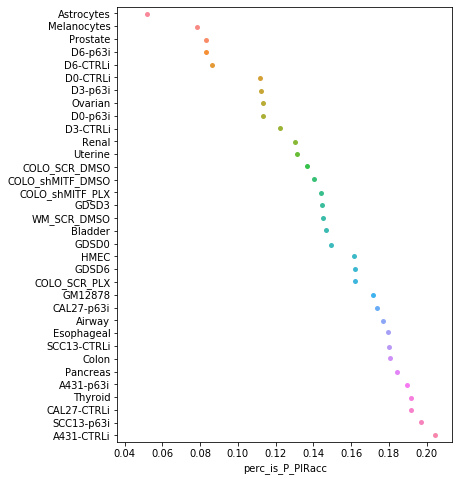

In [61]:
fig = plt.figure(figsize=(6, 8))
sns.stripplot(y = numbers_P_PIRacc.sort_values('perc_is_P_PIRacc').index, x= numbers_P_PIRacc.sort_values('perc_is_P_PIRacc').perc_is_P_PIRacc)

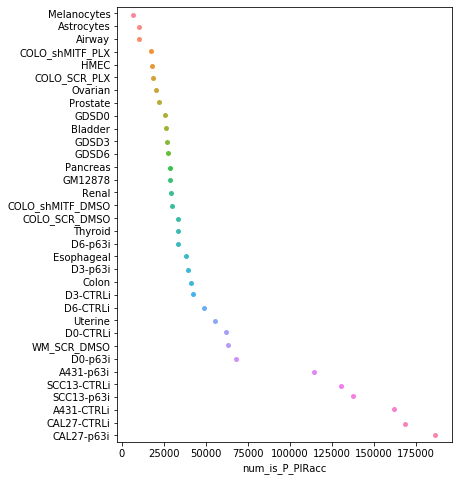

In [62]:
fig = plt.figure(figsize=(6, 8))
sns.stripplot(y = numbers_P_PIRacc.sort_values('num_is_P_PIRacc').index, x= numbers_P_PIRacc.sort_values('num_is_P_PIRacc').num_is_P_PIRacc)

In [6]:
%%time
P_PIR_gene_classification={}
for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    print(tissue)
    
    # read loop/anchor files
    loop_df = pd.read_csv(loop_file, index_col=0)
    anchor_file = os.path.join(anchor_dir, tissue+'.anchors.csv')
    anchor_df = pd.read_csv(anchor_file, index_col=0)
    
    # read anchor atac annotation
    anchor_annon_file = os.path.join(anchor_annon_dir, tissue+'_annon.bed')
    if not os.path.exists(anchor_annon_file):
        print(tissue, 'not anchor annon file.. skipping')
        continue
    anchor_annon_df = pd.read_csv(anchor_annon_file, names=['chr', 'start', 'stop', 'name', 'atac_chr', 'atac_start', 'atac_stop'], sep='\t')
    anchor_to_count_dict = anchor_annon_df.groupby('name').name.count().to_dict()
    anchors_acc = anchor_to_count_dict.keys()
    
    # read anchor tss annotation
    promoter_anchor_file = os.path.join(promoter_annon_dir, 'promoter_'+tissue+'_annon.bed')
    if not os.path.exists(promoter_anchor_file):
        print(tissue, 'not promoter annon file.. skipping')
        continue
    promoter_anchor_df = pd.read_csv(promoter_anchor_file, names=['chr', 'start', 'stop', 'tss', 'anchor_chr', 'anchor_start', 
                                                             'anchor_stop', 'anchor', 'overlap'], sep='\t')
    promoter_anchors = promoter_anchor_df.anchor.unique()

    loop_df['source_P'] = loop_df.source.isin(promoter_anchors)
    loop_df['target_P'] = loop_df.target.isin(promoter_anchors)
    
    loop_df['source_acc'] = loop_df.source.isin(anchors_acc)
    loop_df['target_acc'] = loop_df.target.isin(anchors_acc)   
    

    loop_df['source_acc_P'] = loop_df['source_acc'] & loop_df['source_P']
    loop_df['target_acc_P'] = loop_df['target_acc'] & loop_df['target_P']
    loop_df['source_acc_PIR'] = loop_df['source_acc'] & (~loop_df['source_P'])
    loop_df['target_acc_PIR'] = loop_df['target_acc'] & (~loop_df['target_P'])
    
    
    loop_df['is_P_P'] = loop_df['source_P'] & loop_df['target_P']
    loop_df['is_P_PIR'] = loop_df['source_P'] ^ loop_df['target_P']
    loop_df['is_PIR_PIR'] = ~(loop_df['source_P'] | loop_df['target_P'])
    
    loop_df['both_anchor_acc'] = loop_df['source_acc'] & loop_df['target_acc']
    loop_df['one_anchor_acc'] = loop_df['source_acc'] ^ loop_df['target_acc']
    loop_df['both_anchor_no_acc'] = ~(loop_df['source_acc'] | loop_df['target_acc'])
  
    loop_df['is_P_PIRacc'] = loop_df['is_P_PIR'] & (loop_df['source_acc_PIR'] | loop_df['target_acc_PIR']) 
    loop_df['is_Pacc_PIRacc'] = loop_df['is_P_PIR'] & loop_df['both_anchor_acc'] 
    loop_df['is_PIRacc_PIRacc'] = loop_df['is_PIR_PIR'] & loop_df['both_anchor_acc'] 
    
    
    ### modification
    num_loops_considered = loop_df['is_P_P'].sum()+loop_df['is_P_PIRacc'].sum()+loop_df['is_PIRacc_PIRacc'].sum()
    perc_is_P_P_adj = loop_df['is_P_P'].sum()/num_loops_considered
    perc_is_P_PIRacc_adj = loop_df['is_P_PIRacc'].sum()/num_loops_considered
    perc_is_PIRacc_PIRacc_adj = loop_df['is_PIRacc_PIRacc'].sum()/num_loops_considered
    
    
    loop_df_P_PIRacc = loop_df[loop_df.is_P_PIRacc]
    loop_df_P_PIRacc['P_column'] = loop_df_P_PIRacc.apply(lambda x: x.source if x.source_P else x.target,axis=1)
    loop_df_P_PIRacc['E_column'] = loop_df_P_PIRacc.apply(lambda x: x.target if x.source_P else x.source,axis=1)
    # get the actual loop
    loop_df_P_PIRacc = loop_df_P_PIRacc.merge(promoter_anchor_df[['anchor','tss']],how='left',left_on='P_column', right_on='anchor')

    # get closest gene to PIRacc
    anchors_bed = pybedtools.BedTool.from_dataframe(anchor_df[['chr','start','end','anchors']]).sort()#.to_dataframe()
    anchors_tss_nearest_df = anchors_bed.closest(tss_bed, d=True).to_dataframe()
    anchors_tss_nearest_df = anchors_tss_nearest_df[['name','thickEnd','itemRgb']]
    anchors_tss_nearest_df.columns = ['anchor_name', 'gene', 'dist_to_TSS']
    loop_df_P_PIRacc = loop_df_P_PIRacc.merge(anchors_tss_nearest_df,how='left',left_on='E_column', right_on='anchor_name')

    # renaming colummns
    loop_df_P_PIRacc = loop_df_P_PIRacc[['P_column', 'E_column', 'is_Pacc_PIRacc', 'tss', 'gene', 'dist_to_TSS']]
    loop_df_P_PIRacc.columns = ['P_column', 'E_column', 'is_Pacc_PIRacc','tss_of_P', 'nearest_gene_to_PIR','dist_to_nearest_gene']

    # get distal/nearest classification
    loop_df_P_PIRacc['is_nearest_gene'] = loop_df_P_PIRacc.nearest_gene_to_PIR == loop_df_P_PIRacc.tss_of_P

    # get numbers for P-PIRacc loops
    P_PIRacc_types = loop_df_P_PIRacc.groupby(['E_column','nearest_gene_to_PIR']).agg({'tss_of_P':'::'.join,'P_column':'count'}).reset_index()
    P_PIRacc_types['E_loops_to_nearest'] = P_PIRacc_types.apply(lambda x: x.nearest_gene_to_PIR in x.tss_of_P, axis=1)
    P_PIRacc_types['type1_distal_only'] = (~P_PIRacc_types.E_loops_to_nearest)
    P_PIRacc_types['type2_nearest_distal'] = P_PIRacc_types.E_loops_to_nearest & (P_PIRacc_types.P_column>1)
    P_PIRacc_types['type3_nearest_only'] = P_PIRacc_types.E_loops_to_nearest & (P_PIRacc_types.P_column==1)
    num_enhancers = len(P_PIRacc_types)
    numE_type1_distal_only = len(P_PIRacc_types[P_PIRacc_types.type1_distal_only])
    numE_type2_nearest_distal = len(P_PIRacc_types[P_PIRacc_types.type2_nearest_distal])
    numE_type3_nearest_only = len(P_PIRacc_types[P_PIRacc_types.type3_nearest_only])    
    num_target_genes = P_PIRacc_types.P_column.sum()
    numP_type1_distal_only = P_PIRacc_types[P_PIRacc_types.type1_distal_only].P_column.sum()
    numP_type2_nearest_distal = P_PIRacc_types[P_PIRacc_types.type2_nearest_distal].P_column.sum()
    numP_type3_nearest_only = P_PIRacc_types[P_PIRacc_types.type3_nearest_only].P_column.sum()
    

    # get numbers for Pacc-PIRacc loops
    loop_df_Pacc_PIRacc = loop_df_P_PIRacc[loop_df_P_PIRacc.is_Pacc_PIRacc]
    Pacc_PIRacc_types = loop_df_Pacc_PIRacc.groupby(['E_column','nearest_gene_to_PIR']).agg({
        'tss_of_P':'::'.join,'P_column':'count',}).reset_index()
    Pacc_PIRacc_types['E_loops_to_nearest'] = Pacc_PIRacc_types.apply(lambda x: x.nearest_gene_to_PIR in x.tss_of_P, axis=1)
    Pacc_PIRacc_types['type1_distal_only'] = (~Pacc_PIRacc_types.E_loops_to_nearest) 
    Pacc_PIRacc_types['type2_nearest_distal'] = Pacc_PIRacc_types.E_loops_to_nearest & (Pacc_PIRacc_types.P_column>1)
    Pacc_PIRacc_types['type3_nearest_only'] = Pacc_PIRacc_types.E_loops_to_nearest & (Pacc_PIRacc_types.P_column==1)
    num_enhancers_Pacc = len(Pacc_PIRacc_types)
    numE_type1_distal_only_Pacc = len(Pacc_PIRacc_types[Pacc_PIRacc_types.type1_distal_only])
    numE_type2_nearest_distal_Pacc = len(Pacc_PIRacc_types[Pacc_PIRacc_types.type2_nearest_distal])
    numE_type3_nearest_only_Pacc = len(Pacc_PIRacc_types[Pacc_PIRacc_types.type3_nearest_only])
    num_target_genes_Pacc = Pacc_PIRacc_types.P_column.sum()
    numP_type1_distal_only_Pacc = Pacc_PIRacc_types[Pacc_PIRacc_types.type1_distal_only].P_column.sum()
    numP_type2_nearest_distal_Pacc = Pacc_PIRacc_types[Pacc_PIRacc_types.type2_nearest_distal].P_column.sum()
    numP_type3_nearest_only_Pacc = Pacc_PIRacc_types[Pacc_PIRacc_types.type3_nearest_only].P_column.sum()
    
    
    P_PIR_gene_classification[tissue] = {'num_loops_considered':num_loops_considered,
                                         'num_loops_P_P':sum(loop_df['is_P_P']),
                                         'num_loops_P_PIRacc':sum(loop_df['is_P_PIRacc']),
                                         'num_loops_PIRacc_PIRacc':sum(loop_df['is_PIRacc_PIRacc']),
                                         'num_enhancers_in_P_PIRacc':num_enhancers,
                                         'numE_type1_distal_only_in_P_PIRacc':numE_type1_distal_only,
                                         'numE_type2_nearest_distal_in_P_PIRacc':numE_type2_nearest_distal,
                                         'numE_type3_nearest_only_in_P_PIRacc':numE_type3_nearest_only,
                                         'num_target_genes_in_P_PIRacc':num_target_genes,
                                         'numP_type1_distal_only':numP_type1_distal_only,
                                         'numP_type2_nearest_distal':numP_type2_nearest_distal,
                                         'numP_type3_nearest_only':numP_type3_nearest_only,
                                         
                                         'num_loops_Pacc_PIRacc':len(loop_df_Pacc_PIRacc),
                                         'num_enhancers_in_Pacc_PIRacc':num_enhancers_Pacc,
                                         'numE_type1_distal_only_in_Pacc_PIRacc':numE_type1_distal_only_Pacc,
                                         'numE_type2_nearest_distal_in_Pacc_PIRacc':numE_type2_nearest_distal_Pacc,
                                         'numE_type3_nearest_only_in_Pacc_PIRacc':numE_type3_nearest_only_Pacc, 
                                         'num_target_genes_in_Pacc_PIRacc':num_target_genes_Pacc,
                                         'numP_type1_distal_only_Pacc':numP_type1_distal_only_Pacc,
                                         'numP_type2_nearest_distal_Pacc':numP_type2_nearest_distal_Pacc,
                                         'numP_type3_nearest_only_Pacc':numP_type3_nearest_only_Pacc
                                           
    }   

A431-CTRLi


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

In [48]:
pd.DataFrame.from_dict(P_PIR_gene_classification,orient='index')

,num_loops_considered,num_loops_P_P,num_loops_P_PIRacc,num_loops_PIRacc_PIRacc,num_enhancers_in_P_PIRacc,numE_type1_distal_only_in_P_PIRacc,numE_type2_nearest_distal_in_P_PIRacc,numE_type3_nearest_only_in_P_PIRacc,num_target_genes_in_P_PIRacc,numP_type1_distal_only,...,numP_type3_nearest_only,num_loops_Pacc_PIRacc,num_enhancers_in_Pacc_PIRacc,numE_type1_distal_only_in_Pacc_PIRacc,numE_type2_nearest_distal_in_Pacc_PIRacc,numE_type3_nearest_only_in_Pacc_PIRacc,num_target_genes_in_Pacc_PIRacc,numP_type1_distal_only_Pacc,numP_type2_nearest_distal_Pacc,numP_type3_nearest_only_Pacc
A431-CTRLi,432024,43299,162066,226659,32502,19244,10906,2352,234729,133478,...,2352,146523,29954,20417,7070,2467,146523,100148,43908,2467
A431-p63i,303041,30377,114566,158098,27746,16463,9002,2281,165346,93891,...,2281,97868,25050,17164,5492,2394,97868,67143,28331,2394
Airway,35629,1703,10128,23798,6830,4411,1168,1251,13136,8401,...,1251,9454,5683,3807,756,1120,9454,6261,2073,1120
Astrocytes,20964,4229,10045,6690,5569,4125,951,493,14155,10091,...,493,4213,2498,2105,161,232,4213,3562,419,232
Bladder,95650,4315,26533,64802,15175,9717,3021,2437,34352,21531,...,2437,22673,12202,8384,1725,2093,22673,15439,5141,2093
CAL27-CTRLi,464915,45359,168396,251160,35564,20754,11922,2888,246033,137095,...,2888,152540,32709,22049,7700,2960,152540,102622,46958,2960
CAL27-p63i,501406,49756,186128,265522,39775,22826,13598,3351,268215,150138,...,3351,153700,36004,24244,8343,3417,153700,104153,46130,3417
COLO_SCR_DMSO,140371,4692,33251,102428,17578,10286,4319,2973,44351,25174,...,2973,31593,15212,9724,2596,2892,31593,20484,8217,2892
COLO_SCR_PLX,70774,3038,18435,49301,11130,7099,2140,1891,24869,15318,...,1891,18234,9671,6576,1321,1774,18234,12337,4123,1774
COLO_shMITF_DMSO,124991,4467,29936,90588,16067,9553,3790,2724,39302,22506,...,2724,27310,13829,8906,2248,2675,27310,17696,6939,2675


In [34]:
P_PIR_gene_classification_df = pd.DataFrame.from_dict(P_PIR_gene_classification,orient='index')
P_PIR_gene_classification_df.to_csv(os.path.join(save_dir, 'P_PIR_gene_classification_df.csv'))
P_PIR_gene_classification_normal_df = P_PIR_gene_classification_df[P_PIR_gene_classification_df.index.isin(normal_tissues)]
P_PIR_gene_classification_normal_df.to_csv(os.path.join(save_dir, 'P_PIR_gene_classification_normal_df.csv'))


# 4. get snp - egene 

# 4A. create snp-egene table

for each snp `name`=`rsid`_`disease_name` 
1. annotate to anchor regions with snp data
2. annotate anchor regions with TSS data (already done just read in)
3. merge with loops
4. a SNP-egene pair where a SNP and egene are found on the same loop (regardless if found on same anchor point or different one)
5. (NOT DONE BECAUSE 1615 combination of diseases, ###TODO make better tissue disease matcher ) add a potential tissue match



In [66]:
snp_file = '../data/external/snp_list_combined.csv'
snp_orig_df = pd.read_csv(snp_file, index_col=0)
snp_orig_df['name'] = snp_orig_df.snp + '__' + snp_orig_df.disease
diseases = snp_orig_df.disease.unique()
snp_orig_df['stop'] = snp_orig_df['loc']+1
snp_df = snp_orig_df[['chr', 'loc', 'stop', 'name']]
snp_df.columns = ['chr', 'start', 'stop', 'name']


snp_df.to_csv('../data/external/snp_list_combined.bed',sep='\t',header=None, index=None)
snp_bed = pybedtools.BedTool.from_dataframe(snp_df).sort()

print(snp_df.shape)
print(len(diseases))
snp_df[:5]

(35203, 4)
1615


,chr,start,stop,name
0,chr1,44171211,44171212,rs56319043__lung
1,chr1,8086527,8086528,rs2294890__brca
2,chr1,108330356,108330357,rs10494075__Thyroid
3,chr5,44876507,44876508,rs4866783__brca
4,chr5,50735307,50735308,rs75282042__brca


In [67]:
# melanocyte_list = ['Melanocytes','COLO_SCR_DMSO', 'COLO_SCR_PLX', 'COLO_shMITF_DMSO', 'COLO_shMITF_PLX',
#                    'WM_SCR_DMSO', 'WM_SCR_PLX', 'WM_shMITF_DMSO', 'WM_shMITF_PLX']
# skin_list = ['GDSD0','GDSD3','GDSD6', 'A431-CTRLi', 'A431-p63i','CAL27-CTRLi', 'CAL27-p63i',
#              'D0-CTRLi', 'D0-p63i', 'D3-CTRLi', 'D3-p63i', 'D6-CTRLi', 'D6-p63i','SCC13-CTRLi', 'SCC13-p63i']
# disease_to_tissue = {
#     '':[],
#     'paad':['Pancreas'], 'brca,ovca':['HMEC','Ovarian'], 'ovca,paad':['Ovarian','Pancreas'], 
#     'melanoma':melanocyte_list, 
#     'colon':['Colon'], 
#     'kidney,skin':['Renal']+skin_list +melanocyte_list, 'colon,lung':['Colon','Airway'], 
#     'bladder,lung,skin':['Bladder','Airway']+skin_list +melanocyte_list,
#     'colon,endometrial':['Colon','Uterine'], 'brca,lung':['HMEC','Airway'], 'kidney':['Renal'], 'Thyroid':['Thy'], 'thyroid':['Thy'], 
#     'endometrial,ovca':['Uter','Ova'], 'skin':['GDSD0','GDSD3','GDSD6','MC'], 'brca':['HMEC'], 'esophagus':['Eso'], 'prad':['Pros'], 
#     'endometrial':['Uter'], 'ovca':['Ova'], 'lung,skin':['Air','GDSD0','GDSD3','GDSD6','MC'], 'lung,ovca':['Air','Ova'], 
#     'cervical':['Uter'], 'lung':['Air'], 'bladder':['Blad'], 'brca,melanoma':['HMEC','MC'], 'lymphoma':['GM12878'], 
#     'colon,melanoma':['Colon','MC'], 'brain':['Astro'], 'melanoma,skin':['GDSD0','GDSD3','GDSD6','MC']
    
# }

In [68]:
%%time
snp_egene_df = pd.DataFrame(columns=['TSS',	'snp_id',	'disease',	'tissue'])
for tissue in tissues:
    # 1. annotate anchors with snp info 
    anchor = pybedtools.BedTool('../data/interim/merged/anchors_bed_sort/'+tissue+'_sort.bed')
    anchor_snp_annon_df = anchor.intersect(snp_bed, wa=True, wb=True, sorted=True, names='anchor').to_dataframe()
    anchor_snp_annon_df.columns = ['chr', 'start', 'stop', 'anchor', 'chr_snp','start_snp', 'stop_snp', 'snp_name']
    anchor_snp_annon_df_filt = anchor_snp_annon_df[['anchor', 'snp_name']]

    # 2. read in tss annotation of anchors
    promoter_file = '../data/interim/annon/promoter_anchors/promoter_'+tissue+'_annon.bed'
    if not os.path.exists(promoter_file):
        print(promoter_file,'does not exist .. skipping')
        continue
    anchor_tss_annon_df = pd.read_csv(promoter_file,sep='\t', header=None)
    anchor_tss_annon_df.columns = ['chr_p','start_p','stop_p','TSS','chr_f','start_f','stop_f','anchor','overlap']
    anchor_tss_annon_df_filt = anchor_tss_annon_df.sort_values('overlap', ascending=False).drop_duplicates(['TSS']).sort_index()
    anchor_tss_annon_df_filt = anchor_tss_annon_df_filt[['anchor','TSS']]

    # 3. merge with loops: read in loop information and annotate loops with snp and tss anchor
    loop_file = '../data/interim/merged/loops/'+tissue+'.loops.csv'
    loop_df = pd.read_csv(loop_file,index_col=0)
    loop_df_rev = loop_df.copy()
    loop_df_rev.columns = ['target','source','count']
    loop_df_bi = pd.concat([loop_df, loop_df_rev],sort=False)
    loop_df_bi = loop_df_bi.merge(anchor_snp_annon_df_filt,how='left',left_on='source',right_on='anchor' )
    loop_df_bi.drop('anchor',axis=1,inplace=True)
    loop_df_bi = loop_df_bi.merge(anchor_snp_annon_df_filt,how='inner',left_on='target',right_on='anchor', suffixes=['_s','_t'] )
    loop_df_bi.drop('anchor',axis=1,inplace=True)
    loop_df_bi = loop_df_bi.merge(anchor_tss_annon_df_filt,how='left',left_on='source',right_on='anchor' )
    loop_df_bi.drop('anchor',axis=1,inplace=True)
    loop_df_bi = loop_df_bi.merge(anchor_tss_annon_df_filt,how='inner',left_on='target',right_on='anchor', suffixes=['_s','_t'] )
    loop_df_bi.drop('anchor',axis=1,inplace=True)

    # 4. a SNP-egene pair where a SNP and egene are found on the same loop (regardless if found on same anchor point or different one)
    tissue_snp_df = loop_df_bi[['snp_name_s',	'snp_name_t',	'TSS_s',	'TSS_t']].fillna('')
    tissue_snp_df['snp_name'] = tissue_snp_df.snp_name_s + '::' + tissue_snp_df.snp_name_t
    tissue_snp_df['TSS'] = tissue_snp_df.TSS_s + '::' + tissue_snp_df.TSS_t
    tissue_snp_df['TSS'] = tissue_snp_df.TSS.str.strip('::')
    tissue_snp_df['snp_name'] = tissue_snp_df.snp_name.str.strip('::')
    tissue_snp_df = tissue_snp_df[['snp_name','TSS']]
    tissue_snp_df = pd.DataFrame(tissue_snp_df.snp_name.str.split('::').to_list(), index=tissue_snp_df.TSS).stack().reset_index('TSS')
    tissue_snp_df.columns = ['TSS', 'snp_name']
    tissue_snp_df = pd.DataFrame(tissue_snp_df.TSS.str.split('::').to_list(), index=tissue_snp_df.snp_name).stack().reset_index([0,'snp_name'])
    tissue_snp_df.columns = ['snp_name', 'TSS']
    tissue_snp_df[['snp_id','disease']]=tissue_snp_df.snp_name.str.split('__',expand=True)
    tissue_snp_df['tissue'] = tissue
    tissue_snp_df.drop('snp_name',axis=1,inplace=True)
    
    # 5. add to overall dataframe
    snp_egene_df = pd.concat([snp_egene_df, tissue_snp_df])
    print(tissue, snp_egene_df.shape)
    

A431-CTRLi (97313, 4)
A431-p63i (187908, 4)
Airway (201815, 4)
Astrocytes (226762, 4)
Bladder (247324, 4)
CAL27-CTRLi (371836, 4)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CAL27-p63i (508461, 4)
COLO_SCR_DMSO (535487, 4)
COLO_SCR_PLX (552259, 4)
COLO_shMITF_DMSO (575442, 4)
COLO_shMITF_PLX (590345, 4)
Colon (627198, 4)
D0-CTRLi (685207, 4)
D0-p63i (743338, 4)
D3-CTRLi (784510, 4)
D3-p63i (820709, 4)
D6-CTRLi (871779, 4)
D6-p63i (916144, 4)
Esophageal (946433, 4)
GDSD0 (970391, 4)
GDSD3 (992320, 4)
GDSD6 (1016736, 4)
GM12878 (1050770, 4)
HMEC (1067282, 4)
Melanocytes (1084796, 4)
Ovarian (1117099, 4)
Pancreas (1141730, 4)
Prostate (1167224, 4)
Renal (1192808, 4)
SCC13-CTRLi (1287740, 4)
SCC13-p63i (1396420, 4)
Thyroid (1427165, 4)
Uterine (1463808, 4)
WM_SCR_DMSO (1513932, 4)
WM_SCR_PLX (1554237, 4)
WM_shMITF_DMSO (1603259, 4)
WM_shMITF_PLX (1645098, 4)
CPU times: user 3min 10s, sys: 6.69 s, total: 3min 16s
Wall time: 1min 1s


In [69]:
snp_egene_df.dropna(inplace=True)
snp_egene_df.to_csv(os.path.join(save_dir,'snp_egene_df.csv'))

In [70]:
snp_egene_normal_df = snp_egene_df[snp_egene_df.tissue.isin(normal_tissues)]
snp_egene_normal_df.to_csv(os.path.join(save_dir, 'snp_egene_normal_df.csv'))

In [71]:
snp_egene_df.shape, snp_egene_normal_df.shape

((1566254, 4), (377711, 4))

# 5. get snp egene distance

In [72]:
TSS_df = pd.read_csv('../data/external/TSS_annon_hg19.csv',index_col=0)


In [73]:
snp_egene_df_wdist = snp_egene_df.merge(TSS_df[['chr','loc','TSS']], how='left', on='TSS')

In [74]:
%%time
# takes awhile (~1-2 min)
snp_egene_df_wdist['name'] = snp_egene_df_wdist.snp_id + '__' + snp_egene_df_wdist.disease
snp_egene_df_wdist = snp_egene_df_wdist.merge(snp_df[['chr','start','name']], how='left', on='name')
snp_egene_df_wdist.dropna(inplace=True)

CPU times: user 7.51 s, sys: 209 ms, total: 7.72 s
Wall time: 2.33 s


In [75]:
snp_egene_df_wdist.shape

(1588054, 9)

In [76]:
snp_egene_df_wdist = snp_egene_df_wdist[snp_egene_df_wdist.chr_x==snp_egene_df_wdist.chr_y]
snp_egene_df_wdist.shape

(1588036, 9)

In [77]:
snp_egene_df_wdist['distance'] = abs(snp_egene_df_wdist['loc'] - snp_egene_df_wdist['start'])
snp_egene_df_wdist = snp_egene_df_wdist[['TSS',	'snp_id',	'disease',	'tissue', 'distance']]

In [78]:
snp_egene_df_wdist.distance.describe()

count    1.588036e+06
mean     6.209803e+04
std      1.750724e+05
min      8.100000e+01
25%      8.988000e+03
50%      1.234200e+04
75%      4.240200e+04
max      1.967917e+06
Name: distance, dtype: float64

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


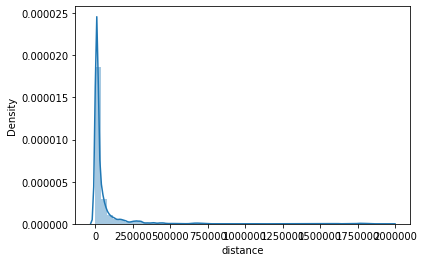

In [79]:
sns.distplot(snp_egene_df_wdist.distance)

In [80]:
snp_egene_df_wdist.to_csv(os.path.join(save_dir,'snp_egene_df_wdist.csv'))
snp_egene_normal_df_wdist = snp_egene_df_wdist[snp_egene_df_wdist.tissue.isin(normal_tissues)]
snp_egene_normal_df_wdist.to_csv(os.path.join(save_dir, 'snp_egene_normal_df_wdist.csv'))


# 6. get average # enhancers that touch a promoter

promoter needs to be expressing

other Pacc that touch said promoter are said to also be enhancers

In [15]:
rna_df = pd.read_csv('../data/interim/rna/tissue_tpm_sym.csv',index_col=0)
rna_df_norm = rna_df[normal_tissues]

In [47]:
for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    print(tissue)
    
    # read loop/anchor files
    loop_df = pd.read_csv(loop_file, index_col=0)
    loop_df_rev = loop_df.copy()
    loop_df_rev.columns = ['target','source','count']
    loop_df_bi = pd.concat([loop_df, loop_df_rev],sort=False)
    anchor_file = os.path.join(anchor_dir, tissue+'.anchors.csv')
    anchor_df = pd.read_csv(anchor_file, index_col=0)
    gene_to_tpm = rna_df[tissue].to_dict()
    
    # read anchor tss annotation
    promoter_anchor_file = os.path.join(promoter_annon_dir, 'promoter_'+tissue+'_annon.bed')
    if not os.path.exists(promoter_anchor_file):
        print(tissue, 'not promoter annon file.. skipping')
        continue
    promoter_anchor_df = pd.read_csv(promoter_anchor_file, names=['chr', 'start', 'stop', 'tss', 'anchor_chr', 'anchor_start', 
                                                             'anchor_stop', 'anchor', 'overlap'], sep='\t')
    promoter_anchors = promoter_anchor_df.anchor.unique()
    
    num_tss_unique_in_anchors = len(promoter_anchor_df.tss.unique())
    num_unique_promoter_anchors = len(promoter_anchor_df.anchor)
    
    # read anchor atac annotation
    anchor_annon_file = os.path.join(anchor_annon_dir, tissue+'_annon.bed')
    if not os.path.exists(anchor_annon_file):
        print(tissue, 'not anchor annon file.. skipping')
        continue
    anchor_annon_df = pd.read_csv(anchor_annon_file, names=['chr', 'start', 'stop', 'name', 'atac_chr', 'atac_start', 'atac_stop'], sep='\t')
    anchor_to_count_dict = anchor_annon_df.groupby('name').name.count().to_dict()
    anchors_acc = anchor_to_count_dict.keys()   
    # add atac annon to anchor annon 
    promoter_anchor_df['num_atac_prom'] = promoter_anchor_df.anchor.map(anchor_to_count_dict).fillna(0)
    # add loop anchors and add atac annon to loop anchor
    promoter_anchor_df = promoter_anchor_df.merge(loop_df_bi, how='left',left_on='anchor',right_on='source').fillna('')
    promoter_anchor_df['num_atac_loop'] = promoter_anchor_df.target.map(anchor_to_count_dict).fillna(0)
    promoter_anchor_df['target_is_P'] = promoter_anchor_df.target.isin(promoter_anchors)
    # filter targets so that they must be accessible
    promoter_anchor_df_filt = promoter_anchor_df[promoter_anchor_df.num_atac_loop>0]
    print(promoter_anchor_df.shape, promoter_anchor_df_filt.shape)
    
    
    # group by gene and get expression tpm of genes
    tss_annon_df = (promoter_anchor_df_filt.groupby('tss')
     .agg({'anchor':[lambda arr: '|'.join(sorted(set(arr))), lambda arr:  len(sorted(set(arr)))],
            'num_atac_prom': sum,
            'target':[lambda arr: '|'.join(sorted(set(arr))), lambda arr:  len(sorted(set(arr)))],
            'num_atac_loop':sum,
            'target_is_P':sum,
          })
     .reset_index()
    )
    tss_annon_df.columns = ['tss','prom_anchors','num_prom_anchors','num_atac_prom',
                            'loop_anchors','num_loop_anchors','num_atac_loop',
                            'target_is_P']
    tss_annon_df['tpm'] = tss_annon_df.tss.map(gene_to_tpm).fillna(0)
    tss_annon_df['is_exp'] = tss_annon_df['tpm'] >1
    break

A431-CTRLi
(381974, 15) (283670, 15)


In [51]:
tss_annon_df.groupby('is_exp').num_loop_anchors.describe()


,count,mean,std,min,25%,50%,75%,max
is_exp,,,,,,,,
False,5877.0,11.138506,13.620159,1.0,2.0,6.0,14.0,137.0
True,8154.0,13.403974,15.331719,1.0,4.0,8.0,17.0,137.0


In [58]:
from scipy.stats import mannwhitneyu, ttest_ind

mannwhitneyu(tss_annon_df[tss_annon_df.is_exp].num_loop_anchors,
             tss_annon_df[~tss_annon_df.is_exp].num_loop_anchors,
             alternative='greater')
#MannwhitneyuResult(statistic=27126202.5, pvalue=3.0504539824857896e-41)

# ttest_ind(tss_annon_df[tss_annon_df.is_exp].num_loop_anchors,
#              tss_annon_df[~tss_annon_df.is_exp].num_loop_anchors)#,
# #              alternative='greater')
#Ttest_indResult(statistic=9.043967565874503, pvalue=1.706302745752929e-19)



MannwhitneyuResult(statistic=27126202.5, pvalue=3.0504539824857896e-41)

In [53]:
tss_annon_df.num_loop_anchors.describe()


count    14031.000000
mean        12.455064
std         14.681303
min          1.000000
25%          3.000000
50%          7.000000
75%         16.000000
max        137.000000
Name: num_loop_anchors, dtype: float64

In [25]:
(promoter_anchor_df.groupby('tss')
    .agg({'anchor':lambda arr: '|'.join(sorted(set(arr)))})
    .reset_index()
)

,tss,anchor
0,A1BG,chr19_58845000_58850000|chr19_58850000_5885500...
1,A3GALT2,chr1_33770000_33775000|chr1_33775000_33780000|...
2,A4GALT,chr22_43105000_43110000|chr22_43110000_43115000
3,A4GNT,chr3_137835000_137840000|chr3_137840000_137845000
4,AAAS,chr12_53700000_53705000|chr12_53705000_5371000...
...,...,...
14117,ZYX,chr7_143060000_143065000|chr7_143065000_143070...
14118,ZZEF1,chr17_4030000_4035000|chr17_4035000_4040000
14119,ZZZ3,chr1_78135000_78140000|chr1_78140000_78145000
14120,hsa-mir-1199,chr19_14165000_14170000|chr19_14170000_1417500...


In [ ]:
for loop_file in sorted(loop_files):
    loop_filename = os.path.basename(loop_file)
    tissue = loop_filename.split('.')[0]
    print(tissue)
    
    # read loop/anchor files
    loop_df = pd.read_csv(loop_file, index_col=0)
    anchor_file = os.path.join(anchor_dir, tissue+'.anchors.csv')
    anchor_df = pd.read_csv(anchor_file, index_col=0)
    
    # read anchor atac annotation
    anchor_annon_file = os.path.join(anchor_annon_dir, tissue+'_annon.bed')
    if not os.path.exists(anchor_annon_file):
        print(tissue, 'not anchor annon file.. skipping')
        continue
    anchor_annon_df = pd.read_csv(anchor_annon_file, names=['chr', 'start', 'stop', 'name', 'atac_chr', 'atac_start', 'atac_stop'], sep='\t')
    anchor_to_count_dict = anchor_annon_df.groupby('name').name.count().to_dict()
    anchors_acc = anchor_to_count_dict.keys()
    
    # read anchor tss annotation
    promoter_anchor_file = os.path.join(promoter_annon_dir, 'promoter_'+tissue+'_annon.bed')
    if not os.path.exists(promoter_anchor_file):
        print(tissue, 'not promoter annon file.. skipping')
        continue
    promoter_anchor_df = pd.read_csv(promoter_anchor_file, names=['chr', 'start', 'stop', 'tss', 'anchor_chr', 'anchor_start', 
                                                             'anchor_stop', 'anchor', 'overlap'], sep='\t')
    promoter_anchors = promoter_anchor_df.anchor.unique()

    loop_df['source_P'] = loop_df.source.isin(promoter_anchors)
    loop_df['target_P'] = loop_df.target.isin(promoter_anchors)
    
    loop_df['source_acc'] = loop_df.source.isin(anchors_acc)
    loop_df['target_acc'] = loop_df.target.isin(anchors_acc)   
    

    loop_df['source_acc_P'] = loop_df['source_acc'] & loop_df['source_P']
    loop_df['target_acc_P'] = loop_df['target_acc'] & loop_df['target_P']
    loop_df['source_acc_PIR'] = loop_df['source_acc'] & (~loop_df['source_P'])
    loop_df['target_acc_PIR'] = loop_df['target_acc'] & (~loop_df['target_P'])
    
    
    loop_df['is_P_P'] = loop_df['source_P'] & loop_df['target_P']
    loop_df['is_P_PIR'] = loop_df['source_P'] ^ loop_df['target_P']
    loop_df['is_PIR_PIR'] = ~(loop_df['source_P'] | loop_df['target_P'])
    
    loop_df['both_anchor_acc'] = loop_df['source_acc'] & loop_df['target_acc']
    loop_df['one_anchor_acc'] = loop_df['source_acc'] ^ loop_df['target_acc']
    loop_df['both_anchor_no_acc'] = ~(loop_df['source_acc'] | loop_df['target_acc'])
  
    loop_df['is_P_PIRacc'] = loop_df['is_P_PIR'] & (loop_df['source_acc_PIR'] | loop_df['target_acc_PIR']) 
    loop_df['is_Pacc_PIRacc'] = loop_df['is_P_PIR'] & loop_df['both_anchor_acc'] 
    loop_df['is_PIRacc_PIRacc'] = loop_df['is_PIR_PIR'] & loop_df['both_anchor_acc'] 
    
    